# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
using PyPlot, HDF5
using Statistics

El archivo adjunto **sacadatos.jl** contiene funciones para abrir y ordenar un archivo tipo *hdf5* del programa *Stimfit*.

In [5]:
include("sacadatos.jl")

devuelvedatos (generic function with 1 method)

In [11]:
nomine = "../../Experimentos/h5files/Registros paper/08n08004.hf5"

"../../Experimentos/h5files/Registros paper/08n08004.hf5"

In [19]:
datos = h5open(nomine, "r");
names(datos)

4-element Array{String,1}:
 "IN 5"       
 "channels"   
 "comment"    
 "description"

In [39]:
a=read(datos["channels"]["ch0"])[1]

"IN 5"

In [25]:
names(datos["IN 5"])

108-element Array{String,1}:
 "description"
 "section_000"
 "section_001"
 "section_002"
 "section_003"
 "section_004"
 "section_005"
 "section_006"
 "section_007"
 "section_008"
 "section_009"
 "section_010"
 "section_011"
 ⋮            
 "section_095"
 "section_096"
 "section_097"
 "section_098"
 "section_099"
 "section_100"
 "section_101"
 "section_102"
 "section_103"
 "section_104"
 "section_105"
 "section_106"

In [50]:
constantes, sweps = devuelvedatos2B(datos);
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5Compound{3}((0.05, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 20.0 kHz.


In [51]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const posG=round(Int, postGms*freq)

800

Funciones auxiliares para convertir tiempo (en ms) a intervalos (en indices enteros) y viceversa:

In [52]:
function iart(i::Int,f::Int) 
  #  """function que pasa de intervalos enteros a tiempo en ms"""
aux=i:f
    result=aux./freq
end

function tari(it,ft)
    # funtion que pasa de tiempo en ms a intervalos enteros de indices
    auxi=round(Int, it*freq)
    auxf=round(Int, ft*freq)
    result=auxi:auxf
end

derivadadt(xx::Array, f=freq)=diff(xx).*f

derivadadt (generic function with 2 methods)

Funciones de suavizado (duro y gaussiano), e.g. $ \tilde{x}= \sum_{-2}^{2} x_i /N$

In [53]:
function suaveduro(trazo::Array, nv=9)
# funcion que promedia cada punto sobre sus vecinos
    aux=trazo
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        result[j]=mean(aux[j:j+nv*2])
    end
    return result 
end


gauss(x, sigma)=exp(-(x/sigma)^2/2)

function pesosgauss(desv::Real,n::Int)
# funcion que promedia cada punto sobre sus vecinos, pero con peso gaussiano
    g=zeros(2*n+1)
    for j=-n:n
        g[j+n+1]=gauss(j,desv)
    end
    return g
end
        
function suavegauss(trazo::Array,ms=0.16, fr=freq)
    
    sigma=ms*fr
    cuatronv=round(Int ,  ceil(4*sigma))
    pesos=pesosgauss(sigma,cuatronv)
    pesoT=sum(pesos)
    l=length(trazo)
    cabeza=repeat([trazo[1]],cuatronv)
    cola=repeat([trazo[end]],cuatronv)
    aux=vcat(cabeza,trazo,cola)
    result=zeros(l)
    for j=1:l
        for k=0:cuatronv
        result[j]+=aux[j+k]*pesos[k+1]
        end
    end
    result/=pesoT
    return result 
end

suavegauss (generic function with 3 methods)

La siguiente funcion, **intervalosP**, determina, a partir de la derivada suavizada de un trazo, los intervalos donde posiblemente hay una espiguleta o una espiga, es decir, aquellos cuya derivada es mayor a cierto umbral. 

In [95]:
umbralinf=0.06*freq
umbralsup=0.5*freq

function intervalosP(dtrazo::Array,thres=umbralinf, thres2=umbralsup)
    # recuerdese: dtrazo es la DERIVADA del trazo suavizado, no el trazo.
    #se recomienda usar una diferencia suavizada en dtrazo
    esunbrinco(x)=  x>thres 
    escontiguo(x,y)=(y-x)==1
    result=Dict{Int, Any}()
    preresult=Dict{Int, Array}()
    

    #=
    Este primer loop encuentra los intervalos
    de INDICES contiguos que cumplen estar
    por encima del umbral
    =#
    r=findall(esunbrinco,dtrazo)
    
    if !(isempty(r))
        k=1
        preresult[1]=[]
        for j=1:length(r)-1   
            if escontiguo(r[j], r[j+1])
                push!(preresult[k], r[j+1])
            else
                k+=1
                preresult[k]=[]
            end
         end 
    
        n=length(keys(preresult))
        
    else 
        println("no hay naaaaaada en la seccion")
    end
    
    tamanointervalo=length(dtrazo)
   
    #=
    A partir del diccionario obtenido en el loop anterior:
    1) Buscamos el maximo
    2) Vemos si su valor esta debajo del segundo umbral
    3) si si, procedemos a localizar su posicion en la lista ORIGINAL de datos
    4) devolvemos una lista con todos los numeritos en ese rango de 200 antes a 800 despues
    =#
     n=length(keys(preresult))
    println("tenemos ",  n)
    #println(keys(preresult))
    
    if n>0    
    for j in keys(preresult)
            println(j)
            aux=preresult[j]
            n2=length(aux)
            println(n2, aux, "hay algo mal aqui")
            if n2>0
               (a, lugarlista) =findmax(dtrazo[aux[1]:aux[end]])
          #  println(aux)
            if a<thres2
                lugarreal=aux[lugarlista]
                ai=lugarreal-preG
                af=lugarreal+posG
                (ai<1) ? ai=1 : ai=ai
                (af>tamanointervalo) ? af=tamanointervalo : af=af
                (maximototal, b)=findmax(dtrazo[ai:af])  
                println("vamos bien, ", ai, " ", af, " ", maximototal)
         
                if maximototal<thres2
                    result[j]=ai:af
                end
                
            end # Este cierra el a<thres2 .
                end  #cierra el n2>0
    end
    
    else
       # println(" te dije que no hay naaaada")
    end
    
    return result
end

intervalosP (generic function with 3 methods)

In [96]:
g0(xs::Array ,d1=-71)= xs.-(xs[1]+d1) #funcion que normaliza al valor d1

g0 (generic function with 2 methods)

In [97]:
function average1(data::Dict)
    aux=0
    k=0
    for subs in keys(data)
        for j in keys(data[subs])
            rango=data[subs][j]
            valor=suaves[subs][rango]
            aux=aux.+valor
            k+=1
        end
    end
    result=aux./k
end

average1 (generic function with 1 method)

In [98]:
function risetime(derivada::Array, thresmin=0.25)
    pasaumbral(x)= x > thresmin
    esnegativa(x) = sign(x)==-1
    
    aux1=findfirst(pasaumbral, derivada)
    aux2=findfirst(esnegativa, derivada[aux1:end])
    aux2=aux2+aux1
    result=(aux1, aux2)

end


risetime (generic function with 2 methods)

In [99]:
sign(-20.1)==-1

true

In [100]:
function separamochas(datos::Dict)
    
Limpias=Dict{String,Dict}()
Mochas=Dict{String,Dict}()
longi=preG+posG+1
    
    for subs in keys(datos)
    for j in keys(datos[subs])
        Limpias[subs]=Dict{Int, Array}()
        Mochas[subs]=Dict{Int, Array}()     
        if length(datos[subs][j])==longi
            Limpias[subs][j]=datos[subs][j]
        else
            Mochas[subs][j]=datos[subs][j]
        end
       
        if isempty(Limpias[subs])
            delete!(Limpias, subs)
        end
        
        if isempty(Mochas[subs])
            delete!(Mochas, subs)
        end
       
    end
end

result=(Limpias, Mochas)
end

separamochas (generic function with 1 method)

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [101]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [102]:
suaves=Dict{String, Array}()
derivadas=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    suaves[subs]=suavegauss(sweps[subs])
    derivadas[subs]=derivadadt(suaves[subs])
    
end


In [103]:
derivadas

Dict{String,Array} with 107 entries:
  "section_103" => [0.152188, -0.463816, 0.23029, 2.07579, 0.0776181, -0.406333…
  "section_014" => [-0.152188, -1.05806, -0.386047, -1.03038, -0.577641, 0.7346…
  "section_017" => [-0.837033, -0.492769, -0.779124, -0.499153, -0.735586, -0.1…
  "section_070" => [0.608751, -0.105104, -0.151464, -0.551536, 0.0077193, -1.00…
  "section_048" => [0.0760939, -0.155814, -0.15481, 0.393912, 0.090634, -0.2381…
  "section_050" => [-0.0760939, -0.0724677, -0.443063, -0.183091, 0.173975, -0.…
  "section_094" => [0.38047, -0.702977, 0.28764, -0.678275, 0.500755, 0.383069,…
  "section_067" => [0.228282, -0.315255, -0.167306, -0.298302, -0.41066, -0.348…
  "section_077" => [0.152188, -0.235534, 0.0672237, -0.00112095, -1.139, -0.093…
  "section_078" => [1.2175, 0.931201, 0.860182, 0.973609, 1.06715, 0.311296, -0…
  "section_015" => [0.0760939, -0.992847, 0.341643, 0.556868, 0.253005, 0.27970…
  "section_028" => [0.608751, -0.0290102, 1.44288, -0.104904, 1.43548, -

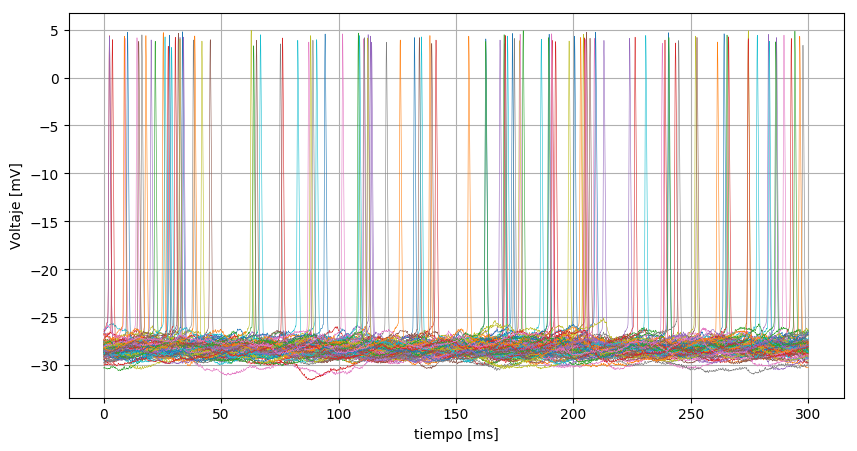

In [104]:
figura=figure(figsize=(10,5))
for subs in keys(suaves)
    lala=length(suaves[subs])
rangot=iart(1, lala)  
 plot(rangot,suaves[subs], label=subs, lw=0.4)
end
#ylim(-80, -50)
#xlim(0.01, 100)
xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
#legend()
grid()

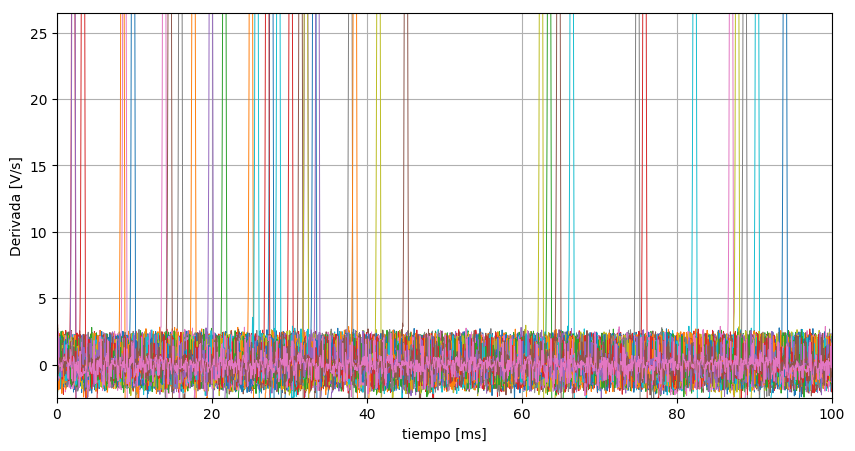

In [105]:
figura=figure(figsize=(10,5))
ylim(-2.5, 26.5)
xlim(0.01, 100)

rangot=1

for subs in keys(derivadas)
lala=length(derivadas[subs])
rangot=iart(1, lala)    
 plot(rangot,derivadas[subs], label=subs, lw=0.7)
end
xlabel("tiempo [ms]")
ylabel("Derivada [V/s]")
#legend()
grid()

In [107]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(derivadas)
    println(subs)
    derivadas[subs]
   intSS[subs]=intervalosP(derivadas[subs], 0.06*freq, 0.4*freq)
end

section_103
tenemos 336
288
0Any[]hay algo mal aqui
306
0Any[]hay algo mal aqui
11
0Any[]hay algo mal aqui
134
0Any[]hay algo mal aqui
158
0Any[]hay algo mal aqui
160
0Any[]hay algo mal aqui
215
0Any[]hay algo mal aqui
29
0Any[]hay algo mal aqui
131
0Any[]hay algo mal aqui
249
0Any[]hay algo mal aqui
207
0Any[]hay algo mal aqui
300
0Any[]hay algo mal aqui
173
0Any[]hay algo mal aqui
289
0Any[]hay algo mal aqui
74
0Any[]hay algo mal aqui
201
0Any[]hay algo mal aqui
176
0Any[]hay algo mal aqui
57
0Any[]hay algo mal aqui
31
0Any[]hay algo mal aqui
285
0Any[]hay algo mal aqui
70
0Any[]hay algo mal aqui
318
0Any[]hay algo mal aqui
33
0Any[]hay algo mal aqui
335
0Any[]hay algo mal aqui
252
0Any[]hay algo mal aqui
114
0Any[]hay algo mal aqui
165
0Any[]hay algo mal aqui
96
0Any[]hay algo mal aqui
133
0Any[]hay algo mal aqui
328
0Any[]hay algo mal aqui
49
0Any[]hay algo mal aqui
84
0Any[]hay algo mal aqui
327
0Any[]hay algo mal aqui
230
0Any[]hay algo mal aqui
117
0Any[]hay algo mal aqui
93
0An

84
0Any[]hay algo mal aqui
230
0Any[]hay algo mal aqui
117
0Any[]hay algo mal aqui
93
0Any[]hay algo mal aqui
284
0Any[]hay algo mal aqui
50
0Any[]hay algo mal aqui
77
0Any[]hay algo mal aqui
80
0Any[]hay algo mal aqui
311
0Any[]hay algo mal aqui
248
0Any[]hay algo mal aqui
227
0Any[]hay algo mal aqui
188
0Any[]hay algo mal aqui
132
0Any[]hay algo mal aqui
195
0Any[]hay algo mal aqui
157
0Any[]hay algo mal aqui
264
0Any[]hay algo mal aqui
231
0Any[]hay algo mal aqui
221
0Any[]hay algo mal aqui
153
0Any[]hay algo mal aqui
217
0Any[]hay algo mal aqui
79
0Any[]hay algo mal aqui
302
0Any[]hay algo mal aqui
71
0Any[]hay algo mal aqui
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui
225
0Any[]hay algo mal aqui
76
0Any[]hay algo mal aqui
184
0Any[]hay algo mal aqui
224
0Any[]hay algo mal aqui
167
0Any[]hay algo mal aqui
213
0Any[]hay algo mal aqui
204
0Any[]hay algo mal aqui
122
0Any[]hay algo mal aqui
143
0Any[]hay algo mal aqui
62
0Any[]hay algo mal aqui
107
0Any[]hay algo mal aqui
1

287
0Any[]hay algo mal aqui
21
0Any[]hay algo mal aqui
10
0Any[]hay algo mal aqui
102
0Any[]hay algo mal aqui
180
0Any[]hay algo mal aqui
294
0Any[]hay algo mal aqui
162
0Any[]hay algo mal aqui
129
0Any[]hay algo mal aqui
280
0Any[]hay algo mal aqui
88
0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251
0Any[]hay algo mal aqui
261
0Any[]hay algo mal aqui
149
0Any[]hay algo mal aqui
5
0Any[]hay algo mal aqui
63
0Any[]hay algo mal aqui
41
0Any[]hay algo mal aqui
15
0Any[]hay algo mal aqui
245
0Any[]hay algo mal aqui
148
0Any[]hay algo mal aqui
210
0Any[]hay algo mal aqui
55
0Any[]hay algo mal aqui
66
0Any[]hay algo mal aqui
239
0Any[]hay algo mal aqui
155
0Any[]hay algo mal aqui
150
0Any[]hay algo mal aqui
209
0Any[]hay algo mal aqui
296
0Any[]hay algo mal aqui
95
0Any[]hay algo mal aqui
139
0Any[]hay algo mal aqui
236
0Any[]hay algo mal aqui
90
0Any[]hay algo mal aqui
111
0Any[]hay algo mal aqui
14
0Any[]hay algo mal aqui
175
0Any[]hay algo mal aqui
205
0

0Any[]hay algo mal aqui
310
0Any[]hay algo mal aqui
265
0Any[]hay algo mal aqui
269
0Any[]hay algo mal aqui
282
0Any[]hay algo mal aqui
135
0Any[]hay algo mal aqui
125
0Any[]hay algo mal aqui
172
0Any[]hay algo mal aqui
146
0Any[]hay algo mal aqui
130
0Any[]hay algo mal aqui
314
0Any[]hay algo mal aqui
17
0Any[]hay algo mal aqui
65
0Any[]hay algo mal aqui
202
0Any[]hay algo mal aqui
44
0Any[]hay algo mal aqui
250
0Any[]hay algo mal aqui
324
0Any[]hay algo mal aqui
37
0Any[]hay algo mal aqui
192
0Any[]hay algo mal aqui
110
0Any[]hay algo mal aqui
127
0Any[]hay algo mal aqui
13
0Any[]hay algo mal aqui
309
0Any[]hay algo mal aqui
270
0Any[]hay algo mal aqui
99
0Any[]hay algo mal aqui
137
0Any[]hay algo mal aqui
141
0Any[]hay algo mal aqui
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
339
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0An

244
0Any[]hay algo mal aqui
273
0Any[]hay algo mal aqui
183
0Any[]hay algo mal aqui
103
0Any[]hay algo mal aqui
152
0Any[]hay algo mal aqui
38
0Any[]hay algo mal aqui
118
0Any[]hay algo mal aqui
48
0Any[]hay algo mal aqui
100
0Any[]hay algo mal aqui
81
0Any[]hay algo mal aqui
140
0Any[]hay algo mal aqui
291
0Any[]hay algo mal aqui
196
0Any[]hay algo mal aqui
19
0Any[]hay algo mal aqui
268
0Any[]hay algo mal aqui
281
0Any[]hay algo mal aqui
51
0Any[]hay algo mal aqui
243
0Any[]hay algo mal aqui
191
0Any[]hay algo mal aqui
177
0Any[]hay algo mal aqui
277
0Any[]hay algo mal aqui
123
0Any[]hay algo mal aqui
255
0Any[]hay algo mal aqui
163
0Any[]hay algo mal aqui
276
0Any[]hay algo mal aqui
301
0Any[]hay algo mal aqui
108
0Any[]hay algo mal aqui
164
0Any[]hay algo mal aqui
2
0Any[]hay algo mal aqui
89
0Any[]hay algo mal aqui
241
0Any[]hay algo mal aqui
197
0Any[]hay algo mal aqui
136
0Any[]hay algo mal aqui
151
0Any[]hay algo mal aqui
144
0Any[]hay algo mal aqui
142
0Any[]hay algo mal aqui


0Any[]hay algo mal aqui
142
0Any[]hay algo mal aqui
283
0Any[]hay algo mal aqui
78
0Any[]hay algo mal aqui
159
0Any[]hay algo mal aqui
112
0Any[]hay algo mal aqui
106
0Any[]hay algo mal aqui
121
0Any[]hay algo mal aqui
109
0Any[]hay algo mal aqui
182
0Any[]hay algo mal aqui
26
0Any[]hay algo mal aqui
279
0Any[]hay algo mal aqui
298
0Any[]hay algo mal aqui
138
0Any[]hay algo mal aqui
4
0Any[]hay algo mal aqui
292
0Any[]hay algo mal aqui
235
3Any[4719, 4720, 4721]hay algo mal aqui
vamos bien, 4521 5521 2.8645929149507054
168
0Any[]hay algo mal aqui
94
0Any[]hay algo mal aqui
290
0Any[]hay algo mal aqui
115
0Any[]hay algo mal aqui
54
0Any[]hay algo mal aqui
40
0Any[]hay algo mal aqui
101
0Any[]hay algo mal aqui
211
0Any[]hay algo mal aqui
171
0Any[]hay algo mal aqui
60
0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
1Any[4772]hay algo mal aqui
vamos bien, 4572 5572 2.8645929149507054
272
0Any[]hay a

0Any[]hay algo mal aqui
211
0Any[]hay algo mal aqui
171
0Any[]hay algo mal aqui
60
0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
0Any[]hay algo mal aqui
313
0Any[]hay algo mal aqui
272
0Any[]hay algo mal aqui
113
0Any[]hay algo mal aqui
293
0Any[]hay algo mal aqui
295
0Any[]hay algo mal aqui
12
0Any[]hay algo mal aqui
242
0Any[]hay algo mal aqui
189
0Any[]hay algo mal aqui
246
0Any[]hay algo mal aqui
16
0Any[]hay algo mal aqui
297
0Any[]hay algo mal aqui
208
0Any[]hay algo mal aqui
274
0Any[]hay algo mal aqui
262
0Any[]hay algo mal aqui
92
0Any[]hay algo mal aqui
72
0Any[]hay algo mal aqui
28
0Any[]hay algo mal aqui
97
0Any[]hay algo mal aqui
68
0Any[]hay algo mal aqui
124
0Any[]hay algo mal aqui
267
0Any[]hay algo mal aqui
275
0Any[]hay algo mal aqui
39
0Any[]hay algo mal aqui
46
0Any[]hay algo mal aqui
85
0Any[]hay algo mal aqui
170
0Any[]hay algo mal aqui
25
0Any[]hay algo mal aqui
42
0Any[]

152
0Any[]hay algo mal aqui
38
0Any[]hay algo mal aqui
118
0Any[]hay algo mal aqui
48
0Any[]hay algo mal aqui
100
0Any[]hay algo mal aqui
81
0Any[]hay algo mal aqui
140
0Any[]hay algo mal aqui
291
0Any[]hay algo mal aqui
196
0Any[]hay algo mal aqui
19
0Any[]hay algo mal aqui
268
0Any[]hay algo mal aqui
281
0Any[]hay algo mal aqui
51
0Any[]hay algo mal aqui
243
0Any[]hay algo mal aqui
191
0Any[]hay algo mal aqui
177
0Any[]hay algo mal aqui
277
0Any[]hay algo mal aqui
123
0Any[]hay algo mal aqui
255
0Any[]hay algo mal aqui
312
0Any[]hay algo mal aqui
317
0Any[]hay algo mal aqui
163
0Any[]hay algo mal aqui
276
0Any[]hay algo mal aqui
301
0Any[]hay algo mal aqui
108
0Any[]hay algo mal aqui
164
0Any[]hay algo mal aqui
329
0Any[]hay algo mal aqui
2
0Any[]hay algo mal aqui
89
0Any[]hay algo mal aqui
241
0Any[]hay algo mal aqui
197
13Any[3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540]hay algo mal aqui
136
0Any[]hay algo mal aqui
151
0Any[]hay algo mal aqui
144
0An

0Any[]hay algo mal aqui
290
0Any[]hay algo mal aqui
115
0Any[]hay algo mal aqui
54
0Any[]hay algo mal aqui
40
0Any[]hay algo mal aqui
101
0Any[]hay algo mal aqui
211
0Any[]hay algo mal aqui
171
0Any[]hay algo mal aqui
60
0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
0Any[]hay algo mal aqui
272
0Any[]hay algo mal aqui
113
0Any[]hay algo mal aqui
293
0Any[]hay algo mal aqui
295
0Any[]hay algo mal aqui
12
0Any[]hay algo mal aqui
242
0Any[]hay algo mal aqui
189
0Any[]hay algo mal aqui
246
0Any[]hay algo mal aqui
16
0Any[]hay algo mal aqui
297
0Any[]hay algo mal aqui
208
0Any[]hay algo mal aqui
274
0Any[]hay algo mal aqui
262
0Any[]hay algo mal aqui
92
0Any[]hay algo mal aqui
72
0Any[]hay algo mal aqui
28
0Any[]hay algo mal aqui
97
0Any[]hay algo mal aqui
68
0Any[]hay algo mal aqui
124
0Any[]hay algo mal aqui
267
0Any[]hay algo mal aqui
275
0Any[]hay algo mal aqui
39
0Any[]hay algo mal aqui
46
0Any[

0Any[]hay algo mal aqui
20
0Any[]hay algo mal aqui
194
0Any[]hay algo mal aqui
52
0Any[]hay algo mal aqui
18
0Any[]hay algo mal aqui
233
0Any[]hay algo mal aqui
266
0Any[]hay algo mal aqui
234
0Any[]hay algo mal aqui
69
0Any[]hay algo mal aqui
232
0Any[]hay algo mal aqui
219
0Any[]hay algo mal aqui
223
0Any[]hay algo mal aqui
166
0Any[]hay algo mal aqui
278
0Any[]hay algo mal aqui
187
0Any[]hay algo mal aqui
35
0Any[]hay algo mal aqui
83
0Any[]hay algo mal aqui
64
0Any[]hay algo mal aqui
286
0Any[]hay algo mal aqui
257
0Any[]hay algo mal aqui
220
0Any[]hay algo mal aqui
145
0Any[]hay algo mal aqui
259
0Any[]hay algo mal aqui
263
0Any[]hay algo mal aqui
45
0Any[]hay algo mal aqui
86
0Any[]hay algo mal aqui
67
0Any[]hay algo mal aqui
126
0Any[]hay algo mal aqui
206
0Any[]hay algo mal aqui
32
0Any[]hay algo mal aqui
229
0Any[]hay algo mal aqui
316
0Any[]hay algo mal aqui
190
0Any[]hay algo mal aqui
303
0Any[]hay algo mal aqui
82
0Any[]hay algo mal aqui
7
0Any[]hay algo mal aqui
75
0Any[]h

0Any[]hay algo mal aqui
98
0Any[]hay algo mal aqui
304
0Any[]hay algo mal aqui
174
0Any[]hay algo mal aqui
319
0Any[]hay algo mal aqui
161
0Any[]hay algo mal aqui
186
0Any[]hay algo mal aqui
321
0Any[]hay algo mal aqui
22
0Any[]hay algo mal aqui
6
0Any[]hay algo mal aqui
24
0Any[]hay algo mal aqui
73
0Any[]hay algo mal aqui
119
0Any[]hay algo mal aqui
156
0Any[]hay algo mal aqui
222
0Any[]hay algo mal aqui
53
0Any[]hay algo mal aqui
116
0Any[]hay algo mal aqui
271
0Any[]hay algo mal aqui
23
0Any[]hay algo mal aqui
305
0Any[]hay algo mal aqui
315
0Any[]hay algo mal aqui
322
0Any[]hay algo mal aqui
27
0Any[]hay algo mal aqui
218
0Any[]hay algo mal aqui
56
0Any[]hay algo mal aqui
section_009
tenemos 308
288
0Any[]hay algo mal aqui
306
0Any[]hay algo mal aqui
11
0Any[]hay algo mal aqui
134
0Any[]hay algo mal aqui
158
0Any[]hay algo mal aqui
160
0Any[]hay algo mal aqui
215
0Any[]hay algo mal aqui
29
0Any[]hay algo mal aqui
131
0Any[]hay algo mal aqui
249
0Any[]hay algo mal aqui
207
0Any[]ha

77
0Any[]hay algo mal aqui
80
0Any[]hay algo mal aqui
311
0Any[]hay algo mal aqui
248
0Any[]hay algo mal aqui
227
0Any[]hay algo mal aqui
188
0Any[]hay algo mal aqui
132
0Any[]hay algo mal aqui
195
0Any[]hay algo mal aqui
157
0Any[]hay algo mal aqui
264
0Any[]hay algo mal aqui
231
0Any[]hay algo mal aqui
221
0Any[]hay algo mal aqui
153
0Any[]hay algo mal aqui
217
0Any[]hay algo mal aqui
79
0Any[]hay algo mal aqui
302
0Any[]hay algo mal aqui
71
0Any[]hay algo mal aqui
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui
225
0Any[]hay algo mal aqui
76
0Any[]hay algo mal aqui
184
0Any[]hay algo mal aqui
224
0Any[]hay algo mal aqui
167
0Any[]hay algo mal aqui
213
0Any[]hay algo mal aqui
204
0Any[]hay algo mal aqui
122
0Any[]hay algo mal aqui
143
0Any[]hay algo mal aqui
62
0Any[]hay algo mal aqui
107
0Any[]hay algo mal aqui
169
0Any[]hay algo mal aqui
287
0Any[]hay algo mal aqui
21
0Any[]hay algo mal aqui
10
0Any[]hay algo mal aqui
102
0Any[]hay algo mal aqui
180
0Any[]hay algo mal aqui


0Any[]hay algo mal aqui
162
0Any[]hay algo mal aqui
129
0Any[]hay algo mal aqui
280
0Any[]hay algo mal aqui
88
0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251
0Any[]hay algo mal aqui
261
0Any[]hay algo mal aqui
149
0Any[]hay algo mal aqui
5
0Any[]hay algo mal aqui
63
0Any[]hay algo mal aqui
331
0Any[]hay algo mal aqui
41
0Any[]hay algo mal aqui
15
0Any[]hay algo mal aqui
245
0Any[]hay algo mal aqui
148
0Any[]hay algo mal aqui
210
0Any[]hay algo mal aqui
55
0Any[]hay algo mal aqui
66
0Any[]hay algo mal aqui
239
0Any[]hay algo mal aqui
155
0Any[]hay algo mal aqui
150
0Any[]hay algo mal aqui
209
0Any[]hay algo mal aqui
296
0Any[]hay algo mal aqui
95
0Any[]hay algo mal aqui
139
0Any[]hay algo mal aqui
236
0Any[]hay algo mal aqui
90
0Any[]hay algo mal aqui
111
0Any[]hay algo mal aqui
14
0Any[]hay algo mal aqui
175
0Any[]hay algo mal aqui
205
0Any[]hay algo mal aqui
253
0Any[]hay algo mal aqui
256
0Any[]hay algo mal aqui
258
0Any[]hay algo mal aqui
212
0An

0Any[]hay algo mal aqui
258
0Any[]hay algo mal aqui
212
0Any[]hay algo mal aqui
200
0Any[]hay algo mal aqui
308
0Any[]hay algo mal aqui
265
0Any[]hay algo mal aqui
269
0Any[]hay algo mal aqui
282
0Any[]hay algo mal aqui
135
0Any[]hay algo mal aqui
125
0Any[]hay algo mal aqui
172
0Any[]hay algo mal aqui
146
0Any[]hay algo mal aqui
130
0Any[]hay algo mal aqui
17
0Any[]hay algo mal aqui
65
0Any[]hay algo mal aqui
202
0Any[]hay algo mal aqui
44
0Any[]hay algo mal aqui
250
0Any[]hay algo mal aqui
37
0Any[]hay algo mal aqui
192
0Any[]hay algo mal aqui
110
0Any[]hay algo mal aqui
127
0Any[]hay algo mal aqui
13
0Any[]hay algo mal aqui
270
0Any[]hay algo mal aqui
99
0Any[]hay algo mal aqui
137
0Any[]hay algo mal aqui
141
0Any[]hay algo mal aqui
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0Any[]hay algo mal aqui
43
0Any

1Any[536]hay algo mal aqui
vamos bien, 336 1336 2.636910403395092
252
0Any[]hay algo mal aqui
114
0Any[]hay algo mal aqui
165
0Any[]hay algo mal aqui
96
0Any[]hay algo mal aqui
133
0Any[]hay algo mal aqui
49
1Any[1177]hay algo mal aqui
vamos bien, 977 1977 2.6169677802084124
84
0Any[]hay algo mal aqui
230
0Any[]hay algo mal aqui
117
0Any[]hay algo mal aqui
93
0Any[]hay algo mal aqui
284
0Any[]hay algo mal aqui
50
1Any[1192]hay algo mal aqui
vamos bien, 992 1992 2.6169677802084124
77
0Any[]hay algo mal aqui
80
0Any[]hay algo mal aqui
248
0Any[]hay algo mal aqui
227
0Any[]hay algo mal aqui
188
0Any[]hay algo mal aqui
132
0Any[]hay algo mal aqui
195
0Any[]hay algo mal aqui
157
0Any[]hay algo mal aqui
264
0Any[]hay algo mal aqui
231
0Any[]hay algo mal aqui
221
0Any[]hay algo mal aqui
153
0Any[]hay algo mal aqui
217
0Any[]hay algo mal aqui
79
0Any[]hay algo mal aqui
71
1Any[1920]hay algo mal aqui
vamos bien, 1720 2720 2.555924553046154
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui

153
0Any[]hay algo mal aqui
217
0Any[]hay algo mal aqui
79
0Any[]hay algo mal aqui
302
0Any[]hay algo mal aqui
71
0Any[]hay algo mal aqui
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui
225
0Any[]hay algo mal aqui
76
0Any[]hay algo mal aqui
184
0Any[]hay algo mal aqui
224
0Any[]hay algo mal aqui
167
0Any[]hay algo mal aqui
213
0Any[]hay algo mal aqui
204
0Any[]hay algo mal aqui
122
0Any[]hay algo mal aqui
143
0Any[]hay algo mal aqui
62
0Any[]hay algo mal aqui
107
0Any[]hay algo mal aqui
169
0Any[]hay algo mal aqui
287
0Any[]hay algo mal aqui
21
0Any[]hay algo mal aqui
10
0Any[]hay algo mal aqui
102
0Any[]hay algo mal aqui
180
0Any[]hay algo mal aqui
294
0Any[]hay algo mal aqui
162
0Any[]hay algo mal aqui
129
0Any[]hay algo mal aqui
280
0Any[]hay algo mal aqui
88
0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251
0Any[]hay algo mal aqui
261
0Any[]hay algo mal aqui
149
0Any[]hay algo mal aqui
5
0Any[]hay algo mal aqui
63
0Any[]hay algo mal aqui
41

0Any[]hay algo mal aqui
150
0Any[]hay algo mal aqui
209
0Any[]hay algo mal aqui
296
0Any[]hay algo mal aqui
95
0Any[]hay algo mal aqui
139
0Any[]hay algo mal aqui
236
0Any[]hay algo mal aqui
90
0Any[]hay algo mal aqui
111
0Any[]hay algo mal aqui
14
0Any[]hay algo mal aqui
175
0Any[]hay algo mal aqui
205
0Any[]hay algo mal aqui
253
0Any[]hay algo mal aqui
256
0Any[]hay algo mal aqui
258
0Any[]hay algo mal aqui
212
0Any[]hay algo mal aqui
200
0Any[]hay algo mal aqui
308
0Any[]hay algo mal aqui
310
0Any[]hay algo mal aqui
265
0Any[]hay algo mal aqui
269
0Any[]hay algo mal aqui
282
0Any[]hay algo mal aqui
135
0Any[]hay algo mal aqui
125
0Any[]hay algo mal aqui
172
0Any[]hay algo mal aqui
146
0Any[]hay algo mal aqui
130
0Any[]hay algo mal aqui
314
0Any[]hay algo mal aqui
17
0Any[]hay algo mal aqui
65
0Any[]hay algo mal aqui
202
0Any[]hay algo mal aqui
44
0Any[]hay algo mal aqui
250
0Any[]hay algo mal aqui
324
0Any[]hay algo mal aqui
37
0Any[]hay algo mal aqui
192
0Any[]hay algo mal aqui
110

0Any[]hay algo mal aqui
127
0Any[]hay algo mal aqui
13
0Any[]hay algo mal aqui
309
0Any[]hay algo mal aqui
270
0Any[]hay algo mal aqui
99
0Any[]hay algo mal aqui
137
0Any[]hay algo mal aqui
141
0Any[]hay algo mal aqui
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0Any[]hay algo mal aqui
43
0Any[]hay algo mal aqui
9
0Any[]hay algo mal aqui
128
0Any[]hay algo mal aqui
203
0Any[]hay algo mal aqui
147
0Any[]hay algo mal aqui
104
0Any[]hay algo mal aqui
244
0Any[]hay algo mal aqui
273
0Any[]hay algo mal aqui
183
0Any[]hay algo mal aqui
103
0Any[]hay algo mal aqui
320
0Any[]hay algo mal aqui
152
0Any[]hay algo mal aqui
38
0Any[]hay algo mal aqui
118
0Any[]hay algo mal aqui
48
0Any[]hay algo mal aqui
100
0Any[]hay algo mal aqui
81
0Any[]hay algo mal aqui
140
0Any[]hay algo mal aqui
291
0Any[]hay algo mal aqui
196
0Any[

0Any[]hay algo mal aqui
177
0Any[]hay algo mal aqui
277
0Any[]hay algo mal aqui
123
0Any[]hay algo mal aqui
255
0Any[]hay algo mal aqui
312
0Any[]hay algo mal aqui
317
0Any[]hay algo mal aqui
163
0Any[]hay algo mal aqui
276
0Any[]hay algo mal aqui
301
0Any[]hay algo mal aqui
108
0Any[]hay algo mal aqui
164
0Any[]hay algo mal aqui
329
0Any[]hay algo mal aqui
2
0Any[]hay algo mal aqui
89
0Any[]hay algo mal aqui
241
0Any[]hay algo mal aqui
197
0Any[]hay algo mal aqui
136
0Any[]hay algo mal aqui
151
0Any[]hay algo mal aqui
144
0Any[]hay algo mal aqui
142
0Any[]hay algo mal aqui
342
0Any[]hay algo mal aqui
283
0Any[]hay algo mal aqui
78
0Any[]hay algo mal aqui
159
0Any[]hay algo mal aqui
112
0Any[]hay algo mal aqui
106
0Any[]hay algo mal aqui
121
0Any[]hay algo mal aqui
109
0Any[]hay algo mal aqui
182
0Any[]hay algo mal aqui
26
0Any[]hay algo mal aqui
279
0Any[]hay algo mal aqui
298
0Any[]hay algo mal aqui
138
0Any[]hay algo mal aqui
4
0Any[]hay algo mal aqui
292
0Any[]hay algo mal aqui
235

0Any[]hay algo mal aqui
101
0Any[]hay algo mal aqui
211
0Any[]hay algo mal aqui
171
0Any[]hay algo mal aqui
60
0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
0Any[]hay algo mal aqui
272
0Any[]hay algo mal aqui
113
0Any[]hay algo mal aqui
293
0Any[]hay algo mal aqui
295
0Any[]hay algo mal aqui
12
0Any[]hay algo mal aqui
242
0Any[]hay algo mal aqui
189
0Any[]hay algo mal aqui
246
0Any[]hay algo mal aqui
16
0Any[]hay algo mal aqui
297
0Any[]hay algo mal aqui
208
0Any[]hay algo mal aqui
274
0Any[]hay algo mal aqui
262
0Any[]hay algo mal aqui
92
0Any[]hay algo mal aqui
72
0Any[]hay algo mal aqui
28
0Any[]hay algo mal aqui
97
0Any[]hay algo mal aqui
68
0Any[]hay algo mal aqui
124
0Any[]hay algo mal aqui
267
0Any[]hay algo mal aqui
275
0Any[]hay algo mal aqui
39
0Any[]hay algo mal aqui
46
0Any[]hay algo mal aqui
85
0Any[]hay algo mal aqui
170
0Any[]hay algo mal aqui
25
0Any[]hay algo mal aqui
42
0Any[]

0Any[]hay algo mal aqui
185
0Any[]hay algo mal aqui
20
0Any[]hay algo mal aqui
194
0Any[]hay algo mal aqui
52
0Any[]hay algo mal aqui
18
0Any[]hay algo mal aqui
233
0Any[]hay algo mal aqui
266
0Any[]hay algo mal aqui
234
0Any[]hay algo mal aqui
69
0Any[]hay algo mal aqui
232
0Any[]hay algo mal aqui
219
0Any[]hay algo mal aqui
223
0Any[]hay algo mal aqui
166
0Any[]hay algo mal aqui
278
0Any[]hay algo mal aqui
187
0Any[]hay algo mal aqui
35
0Any[]hay algo mal aqui
83
0Any[]hay algo mal aqui
64
0Any[]hay algo mal aqui
286
0Any[]hay algo mal aqui
257
0Any[]hay algo mal aqui
220
0Any[]hay algo mal aqui
145
0Any[]hay algo mal aqui
259
0Any[]hay algo mal aqui
263
0Any[]hay algo mal aqui
45
0Any[]hay algo mal aqui
86
0Any[]hay algo mal aqui
67
0Any[]hay algo mal aqui
126
0Any[]hay algo mal aqui
206
0Any[]hay algo mal aqui
32
0Any[]hay algo mal aqui
229
0Any[]hay algo mal aqui
316
0Any[]hay algo mal aqui
190
0Any[]hay algo mal aqui
303
0Any[]hay algo mal aqui
82
0Any[]hay algo mal aqui
7
0Any[]

0Any[]hay algo mal aqui
132
0Any[]hay algo mal aqui
195
0Any[]hay algo mal aqui
157
0Any[]hay algo mal aqui
264
0Any[]hay algo mal aqui
231
0Any[]hay algo mal aqui
221
0Any[]hay algo mal aqui
153
0Any[]hay algo mal aqui
217
0Any[]hay algo mal aqui
79
0Any[]hay algo mal aqui
71
0Any[]hay algo mal aqui
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui
225
0Any[]hay algo mal aqui
76
0Any[]hay algo mal aqui
184
0Any[]hay algo mal aqui
224
0Any[]hay algo mal aqui
167
0Any[]hay algo mal aqui
213
0Any[]hay algo mal aqui
204
0Any[]hay algo mal aqui
122
0Any[]hay algo mal aqui
143
0Any[]hay algo mal aqui
62
0Any[]hay algo mal aqui
107
0Any[]hay algo mal aqui
169
0Any[]hay algo mal aqui
287
0Any[]hay algo mal aqui
21
0Any[]hay algo mal aqui
10
0Any[]hay algo mal aqui
102
0Any[]hay algo mal aqui
180
0Any[]hay algo mal aqui
162
0Any[]hay algo mal aqui
129
0Any[]hay algo mal aqui
280
0Any[]hay algo mal aqui
88
0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251

135
0Any[]hay algo mal aqui
125
0Any[]hay algo mal aqui
172
0Any[]hay algo mal aqui
146
0Any[]hay algo mal aqui
130
0Any[]hay algo mal aqui
314
0Any[]hay algo mal aqui
17
0Any[]hay algo mal aqui
65
0Any[]hay algo mal aqui
202
0Any[]hay algo mal aqui
44
0Any[]hay algo mal aqui
250
0Any[]hay algo mal aqui
37
0Any[]hay algo mal aqui
192
0Any[]hay algo mal aqui
110
0Any[]hay algo mal aqui
127
0Any[]hay algo mal aqui
13
0Any[]hay algo mal aqui
309
0Any[]hay algo mal aqui
270
0Any[]hay algo mal aqui
99
0Any[]hay algo mal aqui
137
0Any[]hay algo mal aqui
141
0Any[]hay algo mal aqui
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0Any[]hay algo mal aqui
43
0Any[]hay algo mal aqui
9
0Any[]hay algo mal aqui
128
0Any[]hay algo mal aqui
203
0Any[]hay algo mal aqui
147
0Any[]hay algo mal aqui
104
0Any[]hay algo mal aqui
244
0A

vamos bien, 2205 3205 82.06444384354552
141
1Any[2462]hay algo mal aqui
vamos bien, 2262 3262 2.771938297543528
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0Any[]hay algo mal aqui
43
0Any[]hay algo mal aqui
9
0Any[]hay algo mal aqui
128
0Any[]hay algo mal aqui
203
0Any[]hay algo mal aqui
147
0Any[]hay algo mal aqui
104
0Any[]hay algo mal aqui
244
0Any[]hay algo mal aqui
273
0Any[]hay algo mal aqui
183
0Any[]hay algo mal aqui
103
0Any[]hay algo mal aqui
152
1Any[2820]hay algo mal aqui
vamos bien, 2620 3620 2.8939549854623436
38
0Any[]hay algo mal aqui
118
0Any[]hay algo mal aqui
48
0Any[]hay algo mal aqui
100
0Any[]hay algo mal aqui
81
0Any[]hay algo mal aqui
140
3Any[2450, 2451, 2452]hay algo mal aqui
vamos bien, 2250 3250 2.771938297543528
291
0Any[]hay algo mal aqui
196
0Any[]hay algo mal aqui
19
0Any[]hay a

0Any[]hay algo mal aqui
140
0Any[]hay algo mal aqui
291
0Any[]hay algo mal aqui
196
0Any[]hay algo mal aqui
19
0Any[]hay algo mal aqui
268
0Any[]hay algo mal aqui
281
0Any[]hay algo mal aqui
51
0Any[]hay algo mal aqui
243
0Any[]hay algo mal aqui
191
0Any[]hay algo mal aqui
177
0Any[]hay algo mal aqui
277
0Any[]hay algo mal aqui
123
0Any[]hay algo mal aqui
255
0Any[]hay algo mal aqui
312
0Any[]hay algo mal aqui
317
0Any[]hay algo mal aqui
163
0Any[]hay algo mal aqui
276
0Any[]hay algo mal aqui
301
0Any[]hay algo mal aqui
108
0Any[]hay algo mal aqui
164
0Any[]hay algo mal aqui
2
0Any[]hay algo mal aqui
89
0Any[]hay algo mal aqui
241
0Any[]hay algo mal aqui
197
0Any[]hay algo mal aqui
136
0Any[]hay algo mal aqui
151
0Any[]hay algo mal aqui
144
0Any[]hay algo mal aqui
142
0Any[]hay algo mal aqui
283
0Any[]hay algo mal aqui
78
0Any[]hay algo mal aqui
159
0Any[]hay algo mal aqui
112
0Any[]hay algo mal aqui
106
0Any[]hay algo mal aqui
121
0Any[]hay algo mal aqui
109
0Any[]hay algo mal aqui
18

0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
0Any[]hay algo mal aqui
272
0Any[]hay algo mal aqui
113
0Any[]hay algo mal aqui
293
0Any[]hay algo mal aqui
295
0Any[]hay algo mal aqui
12
0Any[]hay algo mal aqui
242
0Any[]hay algo mal aqui
189
0Any[]hay algo mal aqui
246
0Any[]hay algo mal aqui
16
0Any[]hay algo mal aqui
297
0Any[]hay algo mal aqui
208
0Any[]hay algo mal aqui
274
0Any[]hay algo mal aqui
262
0Any[]hay algo mal aqui
92
0Any[]hay algo mal aqui
72
0Any[]hay algo mal aqui
28
0Any[]hay algo mal aqui
97
0Any[]hay algo mal aqui
68
0Any[]hay algo mal aqui
124
0Any[]hay algo mal aqui
267
0Any[]hay algo mal aqui
275
0Any[]hay algo mal aqui
39
0Any[]hay algo mal aqui
46
0Any[]hay algo mal aqui
85
0Any[]hay algo mal aqui
170
0Any[]hay algo mal aqui
25
0Any[]hay algo mal aqui
42
0Any[]hay algo mal aqui
181
0Any[]hay algo mal aqui
58
0Any[]hay algo mal aqui
193
0Any[]hay algo mal aqui
59
0Any[]h

263
0Any[]hay algo mal aqui
45
0Any[]hay algo mal aqui
86
0Any[]hay algo mal aqui
67
0Any[]hay algo mal aqui
126
0Any[]hay algo mal aqui
206
0Any[]hay algo mal aqui
32
0Any[]hay algo mal aqui
229
0Any[]hay algo mal aqui
190
0Any[]hay algo mal aqui
82
0Any[]hay algo mal aqui
7
0Any[]hay algo mal aqui
75
0Any[]hay algo mal aqui
228
0Any[]hay algo mal aqui
87
0Any[]hay algo mal aqui
237
0Any[]hay algo mal aqui
179
0Any[]hay algo mal aqui
3
0Any[]hay algo mal aqui
61
0Any[]hay algo mal aqui
36
0Any[]hay algo mal aqui
98
0Any[]hay algo mal aqui
174
0Any[]hay algo mal aqui
161
0Any[]hay algo mal aqui
186
0Any[]hay algo mal aqui
22
0Any[]hay algo mal aqui
6
0Any[]hay algo mal aqui
24
0Any[]hay algo mal aqui
73
0Any[]hay algo mal aqui
119
0Any[]hay algo mal aqui
156
0Any[]hay algo mal aqui
222
0Any[]hay algo mal aqui
53
0Any[]hay algo mal aqui
116
0Any[]hay algo mal aqui
271
0Any[]hay algo mal aqui
23
0Any[]hay algo mal aqui
27
0Any[]hay algo mal aqui
218
0Any[]hay algo mal aqui
56
0Any[]hay a

0Any[]hay algo mal aqui
131
0Any[]hay algo mal aqui
249
0Any[]hay algo mal aqui
207
0Any[]hay algo mal aqui
300
0Any[]hay algo mal aqui
173
0Any[]hay algo mal aqui
289
0Any[]hay algo mal aqui
74
0Any[]hay algo mal aqui
201
0Any[]hay algo mal aqui
176
0Any[]hay algo mal aqui
57
0Any[]hay algo mal aqui
31
0Any[]hay algo mal aqui
285
0Any[]hay algo mal aqui
70
0Any[]hay algo mal aqui
33
0Any[]hay algo mal aqui
252
0Any[]hay algo mal aqui
114
0Any[]hay algo mal aqui
165
0Any[]hay algo mal aqui
96
0Any[]hay algo mal aqui
133
0Any[]hay algo mal aqui
49
0Any[]hay algo mal aqui
84
0Any[]hay algo mal aqui
230
0Any[]hay algo mal aqui
117
0Any[]hay algo mal aqui
93
0Any[]hay algo mal aqui
284
0Any[]hay algo mal aqui
50
0Any[]hay algo mal aqui
77
0Any[]hay algo mal aqui
80
0Any[]hay algo mal aqui
311
0Any[]hay algo mal aqui
248
0Any[]hay algo mal aqui
227
0Any[]hay algo mal aqui
188
0Any[]hay algo mal aqui
132
0Any[]hay algo mal aqui
195
0Any[]hay algo mal aqui
157
0Any[]hay algo mal aqui
264
0Any

0Any[]hay algo mal aqui
8
0Any[]hay algo mal aqui
333
0Any[]hay algo mal aqui
199
0Any[]hay algo mal aqui
323
0Any[]hay algo mal aqui
254
0Any[]hay algo mal aqui
247
0Any[]hay algo mal aqui
185
0Any[]hay algo mal aqui
20
0Any[]hay algo mal aqui
194
0Any[]hay algo mal aqui
52
0Any[]hay algo mal aqui
18
0Any[]hay algo mal aqui
233
0Any[]hay algo mal aqui
266
0Any[]hay algo mal aqui
234
0Any[]hay algo mal aqui
69
0Any[]hay algo mal aqui
232
0Any[]hay algo mal aqui
219
0Any[]hay algo mal aqui
223
0Any[]hay algo mal aqui
166
0Any[]hay algo mal aqui
278
0Any[]hay algo mal aqui
187
0Any[]hay algo mal aqui
35
0Any[]hay algo mal aqui
83
0Any[]hay algo mal aqui
64
0Any[]hay algo mal aqui
286
0Any[]hay algo mal aqui
257
0Any[]hay algo mal aqui
220
0Any[]hay algo mal aqui
145
0Any[]hay algo mal aqui
259
0Any[]hay algo mal aqui
263
0Any[]hay algo mal aqui
45
0Any[]hay algo mal aqui
86
0Any[]hay algo mal aqui
67
0Any[]hay algo mal aqui
126
0Any[]hay algo mal aqui
206
0Any[]hay algo mal aqui
32
0Any[

0Any[]hay algo mal aqui
179
0Any[]hay algo mal aqui
3
0Any[]hay algo mal aqui
61
0Any[]hay algo mal aqui
36
0Any[]hay algo mal aqui
98
0Any[]hay algo mal aqui
304
0Any[]hay algo mal aqui
174
0Any[]hay algo mal aqui
161
0Any[]hay algo mal aqui
186
0Any[]hay algo mal aqui
22
0Any[]hay algo mal aqui
6
0Any[]hay algo mal aqui
24
0Any[]hay algo mal aqui
73
0Any[]hay algo mal aqui
119
0Any[]hay algo mal aqui
156
0Any[]hay algo mal aqui
222
0Any[]hay algo mal aqui
53
0Any[]hay algo mal aqui
116
0Any[]hay algo mal aqui
271
0Any[]hay algo mal aqui
23
0Any[]hay algo mal aqui
305
0Any[]hay algo mal aqui
27
0Any[]hay algo mal aqui
218
0Any[]hay algo mal aqui
56
0Any[]hay algo mal aqui
section_063
tenemos 310
288
0Any[]hay algo mal aqui
306
0Any[]hay algo mal aqui
11
0Any[]hay algo mal aqui
134
0Any[]hay algo mal aqui
158
0Any[]hay algo mal aqui
160
0Any[]hay algo mal aqui
215
0Any[]hay algo mal aqui
29
0Any[]hay algo mal aqui
131
0Any[]hay algo mal aqui
249
0Any[]hay algo mal aqui
207
0Any[]hay al

0Any[]hay algo mal aqui
50
0Any[]hay algo mal aqui
77
0Any[]hay algo mal aqui
80
0Any[]hay algo mal aqui
311
0Any[]hay algo mal aqui
248
0Any[]hay algo mal aqui
227
0Any[]hay algo mal aqui
188
0Any[]hay algo mal aqui
132
0Any[]hay algo mal aqui
195
0Any[]hay algo mal aqui
157
0Any[]hay algo mal aqui
264
0Any[]hay algo mal aqui
231
0Any[]hay algo mal aqui
221
0Any[]hay algo mal aqui
153
0Any[]hay algo mal aqui
217
0Any[]hay algo mal aqui
79
0Any[]hay algo mal aqui
302
0Any[]hay algo mal aqui
71
0Any[]hay algo mal aqui
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui
225
0Any[]hay algo mal aqui
76
0Any[]hay algo mal aqui
184
0Any[]hay algo mal aqui
224
0Any[]hay algo mal aqui
167
0Any[]hay algo mal aqui
213
0Any[]hay algo mal aqui
204
0Any[]hay algo mal aqui
122
0Any[]hay algo mal aqui
143
0Any[]hay algo mal aqui
62
0Any[]hay algo mal aqui
107
0Any[]hay algo mal aqui
169
0Any[]hay algo mal aqui
287
0Any[]hay algo mal aqui
21
0Any[]hay algo mal aqui
10
0Any[]hay algo mal aqui
102
0

0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251
0Any[]hay algo mal aqui
261
0Any[]hay algo mal aqui
149
0Any[]hay algo mal aqui
5
0Any[]hay algo mal aqui
63
0Any[]hay algo mal aqui
331
0Any[]hay algo mal aqui
41
0Any[]hay algo mal aqui
15
0Any[]hay algo mal aqui
245
0Any[]hay algo mal aqui
148
0Any[]hay algo mal aqui
210
0Any[]hay algo mal aqui
55
0Any[]hay algo mal aqui
66
0Any[]hay algo mal aqui
239
0Any[]hay algo mal aqui
155
0Any[]hay algo mal aqui
150
0Any[]hay algo mal aqui
209
0Any[]hay algo mal aqui
296
0Any[]hay algo mal aqui
95
0Any[]hay algo mal aqui
139
0Any[]hay algo mal aqui
236
0Any[]hay algo mal aqui
90
0Any[]hay algo mal aqui
111
0Any[]hay algo mal aqui
14
0Any[]hay algo mal aqui
175
0Any[]hay algo mal aqui
205
0Any[]hay algo mal aqui
253
0Any[]hay algo mal aqui
256
0Any[]hay algo mal aqui
258
0Any[]hay algo mal aqui
212
0Any[]hay algo mal aqui
200
0Any[]hay algo mal aqui
308
0Any[]hay algo mal aqui
310
0Any[]hay algo mal aqui
265
0A

135
0Any[]hay algo mal aqui
125
0Any[]hay algo mal aqui
172
0Any[]hay algo mal aqui
146
0Any[]hay algo mal aqui
130
0Any[]hay algo mal aqui
17
0Any[]hay algo mal aqui
65
0Any[]hay algo mal aqui
202
0Any[]hay algo mal aqui
44
0Any[]hay algo mal aqui
250
0Any[]hay algo mal aqui
37
0Any[]hay algo mal aqui
192
0Any[]hay algo mal aqui
110
0Any[]hay algo mal aqui
127
0Any[]hay algo mal aqui
13
0Any[]hay algo mal aqui
270
0Any[]hay algo mal aqui
99
0Any[]hay algo mal aqui
137
0Any[]hay algo mal aqui
141
0Any[]hay algo mal aqui
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0Any[]hay algo mal aqui
43
0Any[]hay algo mal aqui
9
0Any[]hay algo mal aqui
128
0Any[]hay algo mal aqui
203
0Any[]hay algo mal aqui
147
0Any[]hay algo mal aqui
104
0Any[]hay algo mal aqui
244
0Any[]hay algo mal aqui
273
0Any[]hay algo mal aqui
183
0A

0Any[]hay algo mal aqui
19
0Any[]hay algo mal aqui
268
0Any[]hay algo mal aqui
281
0Any[]hay algo mal aqui
51
0Any[]hay algo mal aqui
243
0Any[]hay algo mal aqui
191
0Any[]hay algo mal aqui
177
0Any[]hay algo mal aqui
277
0Any[]hay algo mal aqui
123
15Any[2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178]hay algo mal aqui
255
0Any[]hay algo mal aqui
312
0Any[]hay algo mal aqui
317
15Any[5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667]hay algo mal aqui
163
0Any[]hay algo mal aqui
276
0Any[]hay algo mal aqui
301
0Any[]hay algo mal aqui
108
0Any[]hay algo mal aqui
164
0Any[]hay algo mal aqui
2
0Any[]hay algo mal aqui
89
0Any[]hay algo mal aqui
241
0Any[]hay algo mal aqui
197
0Any[]hay algo mal aqui
136
0Any[]hay algo mal aqui
151
0Any[]hay algo mal aqui
144
0Any[]hay algo mal aqui
142
0Any[]hay algo mal aqui
283
0Any[]hay algo mal aqui
78
0Any[]hay algo mal aqui
159
0Any[]hay algo mal aqui
112
0Any[]hay algo m

0Any[]hay algo mal aqui
211
0Any[]hay algo mal aqui
171
0Any[]hay algo mal aqui
60
0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
0Any[]hay algo mal aqui
272
0Any[]hay algo mal aqui
113
0Any[]hay algo mal aqui
293
0Any[]hay algo mal aqui
295
0Any[]hay algo mal aqui
12
0Any[]hay algo mal aqui
242
0Any[]hay algo mal aqui
189
0Any[]hay algo mal aqui
246
0Any[]hay algo mal aqui
16
0Any[]hay algo mal aqui
297
0Any[]hay algo mal aqui
208
0Any[]hay algo mal aqui
274
0Any[]hay algo mal aqui
262
0Any[]hay algo mal aqui
92
0Any[]hay algo mal aqui
72
0Any[]hay algo mal aqui
28
0Any[]hay algo mal aqui
97
0Any[]hay algo mal aqui
68
0Any[]hay algo mal aqui
124
0Any[]hay algo mal aqui
267
0Any[]hay algo mal aqui
275
0Any[]hay algo mal aqui
39
0Any[]hay algo mal aqui
46
0Any[]hay algo mal aqui
85
0Any[]hay algo mal aqui
170
0Any[]hay algo mal aqui
25
0Any[]hay algo mal aqui
42
0Any[]hay algo mal aqui
181
0Any[]

207
0Any[]hay algo mal aqui
300
0Any[]hay algo mal aqui
173
0Any[]hay algo mal aqui
289
0Any[]hay algo mal aqui
74
0Any[]hay algo mal aqui
201
0Any[]hay algo mal aqui
176
0Any[]hay algo mal aqui
57
0Any[]hay algo mal aqui
31
0Any[]hay algo mal aqui
285
0Any[]hay algo mal aqui
70
0Any[]hay algo mal aqui
318
0Any[]hay algo mal aqui
33
0Any[]hay algo mal aqui
252
0Any[]hay algo mal aqui
114
0Any[]hay algo mal aqui
165
0Any[]hay algo mal aqui
96
0Any[]hay algo mal aqui
133
0Any[]hay algo mal aqui
328
0Any[]hay algo mal aqui
49
0Any[]hay algo mal aqui
84
0Any[]hay algo mal aqui
327
0Any[]hay algo mal aqui
230
0Any[]hay algo mal aqui
117
0Any[]hay algo mal aqui
93
0Any[]hay algo mal aqui
284
0Any[]hay algo mal aqui
50
0Any[]hay algo mal aqui
77
0Any[]hay algo mal aqui
80
0Any[]hay algo mal aqui
311
0Any[]hay algo mal aqui
248
0Any[]hay algo mal aqui
326
0Any[]hay algo mal aqui
227
0Any[]hay algo mal aqui
188
0Any[]hay algo mal aqui
132
0Any[]hay algo mal aqui
195
0Any[]hay algo mal aqui
157


0Any[]hay algo mal aqui
302
0Any[]hay algo mal aqui
71
0Any[]hay algo mal aqui
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui
225
0Any[]hay algo mal aqui
76
0Any[]hay algo mal aqui
184
0Any[]hay algo mal aqui
224
0Any[]hay algo mal aqui
167
0Any[]hay algo mal aqui
213
0Any[]hay algo mal aqui
204
0Any[]hay algo mal aqui
122
0Any[]hay algo mal aqui
143
0Any[]hay algo mal aqui
62
0Any[]hay algo mal aqui
107
0Any[]hay algo mal aqui
169
0Any[]hay algo mal aqui
287
0Any[]hay algo mal aqui
21
0Any[]hay algo mal aqui
10
0Any[]hay algo mal aqui
102
0Any[]hay algo mal aqui
180
0Any[]hay algo mal aqui
294
0Any[]hay algo mal aqui
162
0Any[]hay algo mal aqui
129
0Any[]hay algo mal aqui
280
0Any[]hay algo mal aqui
88
0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251
0Any[]hay algo mal aqui
261
0Any[]hay algo mal aqui
149
0Any[]hay algo mal aqui
5
0Any[]hay algo mal aqui
63
0Any[]hay algo mal aqui
41
0Any[]hay algo mal aqui
15
0Any[]hay algo mal aqui
245
0An

308
0Any[]hay algo mal aqui
310
0Any[]hay algo mal aqui
265
0Any[]hay algo mal aqui
269
0Any[]hay algo mal aqui
282
0Any[]hay algo mal aqui
135
0Any[]hay algo mal aqui
125
0Any[]hay algo mal aqui
172
0Any[]hay algo mal aqui
146
0Any[]hay algo mal aqui
130
0Any[]hay algo mal aqui
314
0Any[]hay algo mal aqui
17
0Any[]hay algo mal aqui
65
0Any[]hay algo mal aqui
202
0Any[]hay algo mal aqui
44
0Any[]hay algo mal aqui
250
0Any[]hay algo mal aqui
324
0Any[]hay algo mal aqui
37
0Any[]hay algo mal aqui
192
0Any[]hay algo mal aqui
110
0Any[]hay algo mal aqui
127
0Any[]hay algo mal aqui
13
0Any[]hay algo mal aqui
309
0Any[]hay algo mal aqui
270
0Any[]hay algo mal aqui
99
0Any[]hay algo mal aqui
137
0Any[]hay algo mal aqui
141
0Any[]hay algo mal aqui
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0Any[]hay algo mal aqui
43


0Any[]hay algo mal aqui
273
0Any[]hay algo mal aqui
183
0Any[]hay algo mal aqui
103
0Any[]hay algo mal aqui
320
0Any[]hay algo mal aqui
152
0Any[]hay algo mal aqui
38
0Any[]hay algo mal aqui
118
0Any[]hay algo mal aqui
48
0Any[]hay algo mal aqui
100
0Any[]hay algo mal aqui
81
0Any[]hay algo mal aqui
140
0Any[]hay algo mal aqui
291
0Any[]hay algo mal aqui
196
0Any[]hay algo mal aqui
19
0Any[]hay algo mal aqui
268
0Any[]hay algo mal aqui
281
0Any[]hay algo mal aqui
51
0Any[]hay algo mal aqui
243
0Any[]hay algo mal aqui
191
0Any[]hay algo mal aqui
177
0Any[]hay algo mal aqui
277
0Any[]hay algo mal aqui
123
0Any[]hay algo mal aqui
255
0Any[]hay algo mal aqui
312
0Any[]hay algo mal aqui
317
0Any[]hay algo mal aqui
163
0Any[]hay algo mal aqui
276
0Any[]hay algo mal aqui
301
0Any[]hay algo mal aqui
108
0Any[]hay algo mal aqui
164
0Any[]hay algo mal aqui
2
0Any[]hay algo mal aqui
89
0Any[]hay algo mal aqui
241
0Any[]hay algo mal aqui
197
0Any[]hay algo mal aqui
136
0Any[]hay algo mal aqui
151


0Any[]hay algo mal aqui
138
0Any[]hay algo mal aqui
4
0Any[]hay algo mal aqui
292
0Any[]hay algo mal aqui
235
0Any[]hay algo mal aqui
168
0Any[]hay algo mal aqui
94
0Any[]hay algo mal aqui
290
0Any[]hay algo mal aqui
115
0Any[]hay algo mal aqui
54
0Any[]hay algo mal aqui
40
0Any[]hay algo mal aqui
101
0Any[]hay algo mal aqui
211
0Any[]hay algo mal aqui
171
0Any[]hay algo mal aqui
60
0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
0Any[]hay algo mal aqui
313
0Any[]hay algo mal aqui
272
0Any[]hay algo mal aqui
113
0Any[]hay algo mal aqui
293
0Any[]hay algo mal aqui
295
0Any[]hay algo mal aqui
12
0Any[]hay algo mal aqui
242
0Any[]hay algo mal aqui
189
0Any[]hay algo mal aqui
246
0Any[]hay algo mal aqui
16
0Any[]hay algo mal aqui
297
0Any[]hay algo mal aqui
208
0Any[]hay algo mal aqui
274
0Any[]hay algo mal aqui
262
0Any[]hay algo mal aqui
92
0Any[]hay algo mal aqui
72
0Any[]hay algo mal aqui
28
0Any

170
0Any[]hay algo mal aqui
25
0Any[]hay algo mal aqui
42
0Any[]hay algo mal aqui
181
0Any[]hay algo mal aqui
58
0Any[]hay algo mal aqui
193
0Any[]hay algo mal aqui
59
0Any[]hay algo mal aqui
8
0Any[]hay algo mal aqui
199
0Any[]hay algo mal aqui
254
0Any[]hay algo mal aqui
247
0Any[]hay algo mal aqui
185
0Any[]hay algo mal aqui
20
0Any[]hay algo mal aqui
194
0Any[]hay algo mal aqui
52
0Any[]hay algo mal aqui
18
0Any[]hay algo mal aqui
233
0Any[]hay algo mal aqui
266
0Any[]hay algo mal aqui
234
0Any[]hay algo mal aqui
69
0Any[]hay algo mal aqui
232
0Any[]hay algo mal aqui
219
0Any[]hay algo mal aqui
223
0Any[]hay algo mal aqui
166
0Any[]hay algo mal aqui
278
0Any[]hay algo mal aqui
187
0Any[]hay algo mal aqui
35
0Any[]hay algo mal aqui
83
0Any[]hay algo mal aqui
64
0Any[]hay algo mal aqui
286
0Any[]hay algo mal aqui
257
0Any[]hay algo mal aqui
220
0Any[]hay algo mal aqui
145
0Any[]hay algo mal aqui
259
0Any[]hay algo mal aqui
263
0Any[]hay algo mal aqui
45
0Any[]hay algo mal aqui
86
0An

0Any[]hay algo mal aqui
82
0Any[]hay algo mal aqui
7
0Any[]hay algo mal aqui
75
0Any[]hay algo mal aqui
228
0Any[]hay algo mal aqui
87
0Any[]hay algo mal aqui
237
0Any[]hay algo mal aqui
179
0Any[]hay algo mal aqui
3
0Any[]hay algo mal aqui
61
0Any[]hay algo mal aqui
36
0Any[]hay algo mal aqui
98
0Any[]hay algo mal aqui
304
0Any[]hay algo mal aqui
174
0Any[]hay algo mal aqui
319
0Any[]hay algo mal aqui
161
0Any[]hay algo mal aqui
186
0Any[]hay algo mal aqui
321
0Any[]hay algo mal aqui
22
0Any[]hay algo mal aqui
6
0Any[]hay algo mal aqui
24
0Any[]hay algo mal aqui
73
0Any[]hay algo mal aqui
119
0Any[]hay algo mal aqui
156
0Any[]hay algo mal aqui
222
0Any[]hay algo mal aqui
53
0Any[]hay algo mal aqui
116
0Any[]hay algo mal aqui
271
0Any[]hay algo mal aqui
23
0Any[]hay algo mal aqui
305
0Any[]hay algo mal aqui
315
0Any[]hay algo mal aqui
322
0Any[]hay algo mal aqui
27
0Any[]hay algo mal aqui
218
0Any[]hay algo mal aqui
56
0Any[]hay algo mal aqui
section_066
tenemos 327
288
0Any[]hay algo 

233
0Any[]hay algo mal aqui
266
0Any[]hay algo mal aqui
234
0Any[]hay algo mal aqui
69
0Any[]hay algo mal aqui
232
0Any[]hay algo mal aqui
219
0Any[]hay algo mal aqui
223
0Any[]hay algo mal aqui
166
0Any[]hay algo mal aqui
278
0Any[]hay algo mal aqui
187
0Any[]hay algo mal aqui
35
0Any[]hay algo mal aqui
83
0Any[]hay algo mal aqui
64
0Any[]hay algo mal aqui
286
0Any[]hay algo mal aqui
257
16Any[4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615]hay algo mal aqui
220
0Any[]hay algo mal aqui
145
0Any[]hay algo mal aqui
259
0Any[]hay algo mal aqui
263
0Any[]hay algo mal aqui
45
0Any[]hay algo mal aqui
86
0Any[]hay algo mal aqui
67
0Any[]hay algo mal aqui
126
0Any[]hay algo mal aqui
206
0Any[]hay algo mal aqui
32
0Any[]hay algo mal aqui
229
0Any[]hay algo mal aqui
316
0Any[]hay algo mal aqui
190
0Any[]hay algo mal aqui
303
0Any[]hay algo mal aqui
82
0Any[]hay algo mal aqui
7
0Any[]hay algo mal aqui
75
0Any[]hay algo mal aqui
228
0Any[]hay algo ma

119
0Any[]hay algo mal aqui
156
0Any[]hay algo mal aqui
222
0Any[]hay algo mal aqui
53
0Any[]hay algo mal aqui
116
0Any[]hay algo mal aqui
271
0Any[]hay algo mal aqui
23
0Any[]hay algo mal aqui
305
0Any[]hay algo mal aqui
27
0Any[]hay algo mal aqui
218
0Any[]hay algo mal aqui
56
0Any[]hay algo mal aqui
section_091
tenemos 313
288
0Any[]hay algo mal aqui
306
0Any[]hay algo mal aqui
11
0Any[]hay algo mal aqui
134
0Any[]hay algo mal aqui
158
0Any[]hay algo mal aqui
160
0Any[]hay algo mal aqui
215
0Any[]hay algo mal aqui
29
0Any[]hay algo mal aqui
131
0Any[]hay algo mal aqui
249
0Any[]hay algo mal aqui
207
0Any[]hay algo mal aqui
300
0Any[]hay algo mal aqui
173
0Any[]hay algo mal aqui
289
0Any[]hay algo mal aqui
74
0Any[]hay algo mal aqui
201
0Any[]hay algo mal aqui
176
0Any[]hay algo mal aqui
57
0Any[]hay algo mal aqui
31
0Any[]hay algo mal aqui
285
0Any[]hay algo mal aqui
70
0Any[]hay algo mal aqui
33
0Any[]hay algo mal aqui
252
0Any[]hay algo mal aqui
114
0Any[]hay algo mal aqui
165
0An

231
0Any[]hay algo mal aqui
221
0Any[]hay algo mal aqui
153
0Any[]hay algo mal aqui
217
0Any[]hay algo mal aqui
79
0Any[]hay algo mal aqui
302
0Any[]hay algo mal aqui
71
0Any[]hay algo mal aqui
120
0Any[]hay algo mal aqui
154
0Any[]hay algo mal aqui
225
0Any[]hay algo mal aqui
76
0Any[]hay algo mal aqui
184
0Any[]hay algo mal aqui
224
0Any[]hay algo mal aqui
167
0Any[]hay algo mal aqui
213
0Any[]hay algo mal aqui
204
0Any[]hay algo mal aqui
122
0Any[]hay algo mal aqui
143
0Any[]hay algo mal aqui
62
0Any[]hay algo mal aqui
107
0Any[]hay algo mal aqui
169
0Any[]hay algo mal aqui
287
0Any[]hay algo mal aqui
21
0Any[]hay algo mal aqui
10
0Any[]hay algo mal aqui
102
0Any[]hay algo mal aqui
180
0Any[]hay algo mal aqui
294
0Any[]hay algo mal aqui
162
0Any[]hay algo mal aqui
129
0Any[]hay algo mal aqui
280
0Any[]hay algo mal aqui
88
0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251
0Any[]hay algo mal aqui
261
0Any[]hay algo mal aqui
149
0Any[]hay algo mal aqui

0Any[]hay algo mal aqui
162
0Any[]hay algo mal aqui
129
0Any[]hay algo mal aqui
280
0Any[]hay algo mal aqui
88
0Any[]hay algo mal aqui
240
0Any[]hay algo mal aqui
260
0Any[]hay algo mal aqui
251
0Any[]hay algo mal aqui
261
0Any[]hay algo mal aqui
149
0Any[]hay algo mal aqui
5
0Any[]hay algo mal aqui
63
3Any[1186, 1187, 1188]hay algo mal aqui
vamos bien, 986 1986 2.601978560360223
41
0Any[]hay algo mal aqui
15
0Any[]hay algo mal aqui
245
0Any[]hay algo mal aqui
148
0Any[]hay algo mal aqui
210
0Any[]hay algo mal aqui
55
0Any[]hay algo mal aqui
66
3Any[1389, 1390, 1391]hay algo mal aqui
vamos bien, 1189 2189 2.715066492282645
239
0Any[]hay algo mal aqui
155
0Any[]hay algo mal aqui
150
0Any[]hay algo mal aqui
209
0Any[]hay algo mal aqui
296
0Any[]hay algo mal aqui
95
2Any[2287, 2288]hay algo mal aqui
vamos bien, 2087 3087 2.892378602095249
139
0Any[]hay algo mal aqui
236
0Any[]hay algo mal aqui
90
1Any[2122]hay algo mal aqui
vamos bien, 1922 2922 2.892378602095249
111
0Any[]hay algo mal aq

0Any[]hay algo mal aqui
296
0Any[]hay algo mal aqui
95
0Any[]hay algo mal aqui
139
0Any[]hay algo mal aqui
236
0Any[]hay algo mal aqui
90
0Any[]hay algo mal aqui
111
0Any[]hay algo mal aqui
14
0Any[]hay algo mal aqui
175
0Any[]hay algo mal aqui
205
0Any[]hay algo mal aqui
253
0Any[]hay algo mal aqui
256
0Any[]hay algo mal aqui
258
0Any[]hay algo mal aqui
212
0Any[]hay algo mal aqui
200
0Any[]hay algo mal aqui
308
0Any[]hay algo mal aqui
310
0Any[]hay algo mal aqui
265
0Any[]hay algo mal aqui
269
0Any[]hay algo mal aqui
282
0Any[]hay algo mal aqui
135
0Any[]hay algo mal aqui
125
0Any[]hay algo mal aqui
172
0Any[]hay algo mal aqui
146
0Any[]hay algo mal aqui
130
0Any[]hay algo mal aqui
314
0Any[]hay algo mal aqui
17
0Any[]hay algo mal aqui
65
0Any[]hay algo mal aqui
202
0Any[]hay algo mal aqui
44
0Any[]hay algo mal aqui
250
0Any[]hay algo mal aqui
324
0Any[]hay algo mal aqui
37
0Any[]hay algo mal aqui
192
0Any[]hay algo mal aqui
110
0Any[]hay algo mal aqui
127
0Any[]hay algo mal aqui
13


137
0Any[]hay algo mal aqui
141
0Any[]hay algo mal aqui
105
0Any[]hay algo mal aqui
30
0Any[]hay algo mal aqui
1
0Any[]hay algo mal aqui
47
0Any[]hay algo mal aqui
216
0Any[]hay algo mal aqui
226
0Any[]hay algo mal aqui
214
0Any[]hay algo mal aqui
307
0Any[]hay algo mal aqui
91
0Any[]hay algo mal aqui
43
0Any[]hay algo mal aqui
9
0Any[]hay algo mal aqui
128
0Any[]hay algo mal aqui
203
0Any[]hay algo mal aqui
147
0Any[]hay algo mal aqui
104
0Any[]hay algo mal aqui
244
0Any[]hay algo mal aqui
273
0Any[]hay algo mal aqui
183
0Any[]hay algo mal aqui
103
0Any[]hay algo mal aqui
320
0Any[]hay algo mal aqui
152
0Any[]hay algo mal aqui
38
0Any[]hay algo mal aqui
118
0Any[]hay algo mal aqui
48
0Any[]hay algo mal aqui
100
0Any[]hay algo mal aqui
81
0Any[]hay algo mal aqui
140
0Any[]hay algo mal aqui
291
0Any[]hay algo mal aqui
196
0Any[]hay algo mal aqui
19
0Any[]hay algo mal aqui
268
0Any[]hay algo mal aqui
281
0Any[]hay algo mal aqui
51
0Any[]hay algo mal aqui
243
0Any[]hay algo mal aqui
191
0

255
0Any[]hay algo mal aqui
312
0Any[]hay algo mal aqui
317
0Any[]hay algo mal aqui
163
0Any[]hay algo mal aqui
276
0Any[]hay algo mal aqui
301
0Any[]hay algo mal aqui
108
0Any[]hay algo mal aqui
164
0Any[]hay algo mal aqui
2
0Any[]hay algo mal aqui
89
0Any[]hay algo mal aqui
241
0Any[]hay algo mal aqui
197
0Any[]hay algo mal aqui
136
0Any[]hay algo mal aqui
151
0Any[]hay algo mal aqui
144
0Any[]hay algo mal aqui
142
0Any[]hay algo mal aqui
283
0Any[]hay algo mal aqui
78
0Any[]hay algo mal aqui
159
0Any[]hay algo mal aqui
112
0Any[]hay algo mal aqui
106
0Any[]hay algo mal aqui
121
0Any[]hay algo mal aqui
109
0Any[]hay algo mal aqui
182
0Any[]hay algo mal aqui
26
0Any[]hay algo mal aqui
279
0Any[]hay algo mal aqui
298
0Any[]hay algo mal aqui
138
0Any[]hay algo mal aqui
4
0Any[]hay algo mal aqui
292
0Any[]hay algo mal aqui
235
0Any[]hay algo mal aqui
168
0Any[]hay algo mal aqui
94
0Any[]hay algo mal aqui
290
0Any[]hay algo mal aqui
115
0Any[]hay algo mal aqui
54
0Any[]hay algo mal aqui
4

Excessive output truncated after 524288 bytes.

[]hay algo mal aqui
211
0Any[]hay algo mal aqui
171
0Any[]hay algo mal aqui
337
0Any[]hay algo mal aqui
60
0Any[]hay algo mal aqui
34
0Any[]hay algo mal aqui
332
0Any[]hay algo mal aqui
334
0Any[]hay algo mal aqui
299
0Any[]hay algo mal aqui
178
0Any[]hay algo mal aqui
198
0Any[]hay algo mal aqui
238
0Any[]hay algo mal aqui
313
0Any[]hay algo mal aqui
272
0Any[]hay algo mal aqui
113
0Any[]hay algo mal aqui
293
0Any[]hay algo mal aqui
295
0Any[]hay algo mal aqui
12
0Any[]hay algo mal aqui
242
0Any[]hay algo mal aqui
343
0Any[]hay algo mal aqui
189
0Any[]hay algo mal aqui
246
0Any[]hay algo mal aqui
16
0Any[]hay algo mal aqui
297
0Any[]hay algo mal aqui
208
0Any[]hay algo mal aqui
274
0Any[]hay algo mal aqui
262
0Any[]hay algo mal aqui
92
0Any[]hay algo mal aqui
72
0Any[]hay algo mal aqui
28
0Any[]hay algo mal aqui
338
0Any[]hay algo mal aqui
97
0Any[]hay algo mal aqui
68
0Any[]hay algo mal aqui
124
0Any[]hay algo mal aqui
267
0Any[]hay algo mal aqui
275
0Any[]hay algo mal aqui
39
0Any[]

In [85]:
derivadas["section_103"]

5999-element Array{Float64,1}:
  0.15218786834985565
 -0.46381614836931817
  0.2302904332277933 
  2.0757862261582005 
  0.07761810967885197
 -0.40633259579230696
 -0.365504018836873  
  0.9094199392863089 
  0.06092764964755304
 -0.05803037511817877
 -0.4695207014469105 
 -0.4643378018393207 
 -1.779778461036372  
  ⋮                  
  0.38019119714050476
 -0.01908916933579974
 -0.32053405307415517
  0.34454475367574844
 -0.567886703500804  
  0.21172793452706173
  1.993736875575678  
  0.0831729139097348 
 -0.08727781724523709
 -0.2854743135932125 
  0.2753384098156886 
  0.34492900914202096

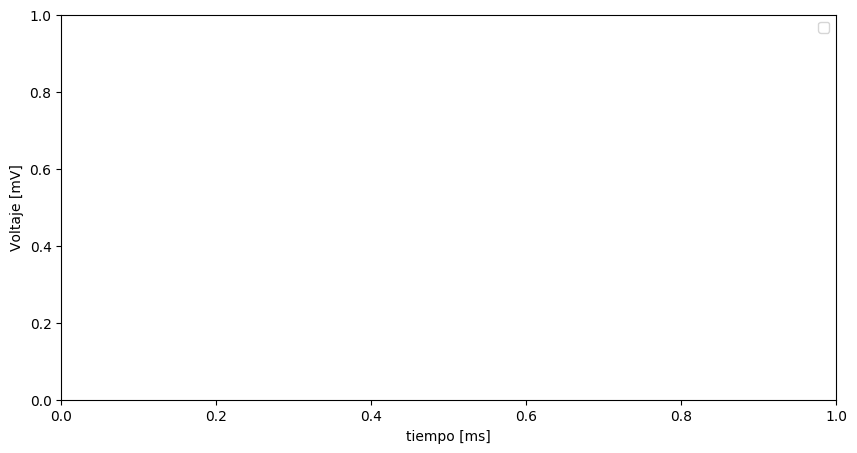

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f46a0c29cc0>

In [125]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,suaves[subs][rango], label=subs)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
legend()

In [126]:
figura=figure(figsize=(10,5))
xlim(13000,14000)
#ylim(-0.02,0.1)
  #rango=intSS[subs][1]
plot(derivadas["section_50"])
#plot(suaves["section_50"])

KeyError: KeyError: key "section_50" not found

In [127]:
(limpia, mocha)=separamochas(intSS);

In [128]:
a=average1(limpia);

In [129]:
normCut=Dict{String,Dict}()
    
for subs in keys(limpia)
    normCut[subs]=Dict{Int, Array}()
    for j in keys(limpia[subs])
         arre=intSS[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        normCut[subs][j]=suaves[subs][rango].-(suaves[subs][rango][1]-a[1])
    end
end

In [130]:
normCut

Dict{String,Dict} with 0 entries

In [131]:
mocha

Dict{String,Dict} with 0 entries

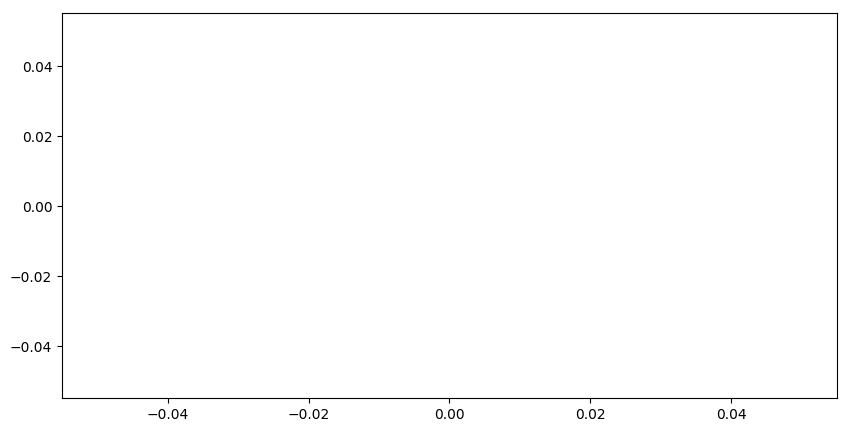

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f467d4cbd30>

In [132]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normCut)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normCut[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(normCut[subs][j])
    end
end

plot(a, lw=3)

**NOTA para avanzar**

En la grafica superior, la linea gruesa es el promedio. Nos interesa calcular el tiempo que le lleva levantarse desde
el cambio en la curvatura (suave a muy empinado) hasta el máximo punto de la funcion.

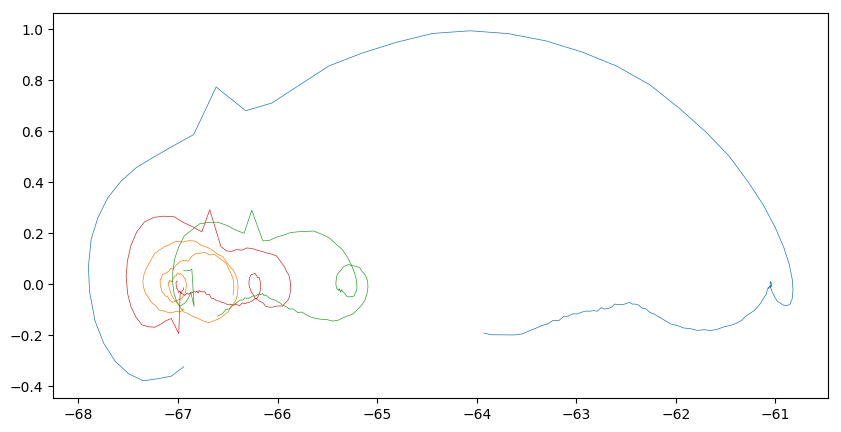

In [93]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), derivadas[subs][rango], lw=0.5)
    end
end
#plot(promSpK[2:end],difProm, lw=5, c="red")

In [94]:
Mochas

UndefVarError: UndefVarError: Mochas not defined

In [95]:
promSpK=a

131-element Array{Float64,1}:
 -66.94157141011317
 -66.9782149100577 
 -67.02044894064481
 -67.06353395745285
 -67.10867741666152
 -67.15081233608517
 -67.21695057486588
 -67.26503075518386
 -67.30465300332263
 -67.33491872027322
 -67.35696450746386
 -67.36779156914663
 -67.3698234143505 
   ⋮               
 -65.78538670130177
 -65.79596303064866
 -65.8071232228461 
 -65.81836058665954
 -65.83306759358028
 -65.84838645734763
 -65.86628373042062
 -65.88732352827515
 -65.91077415953711
 -65.93624543637952
 -65.96363012729107
 -65.99479617451125

In [96]:
riset=risetime(difProm)

(24, 47)

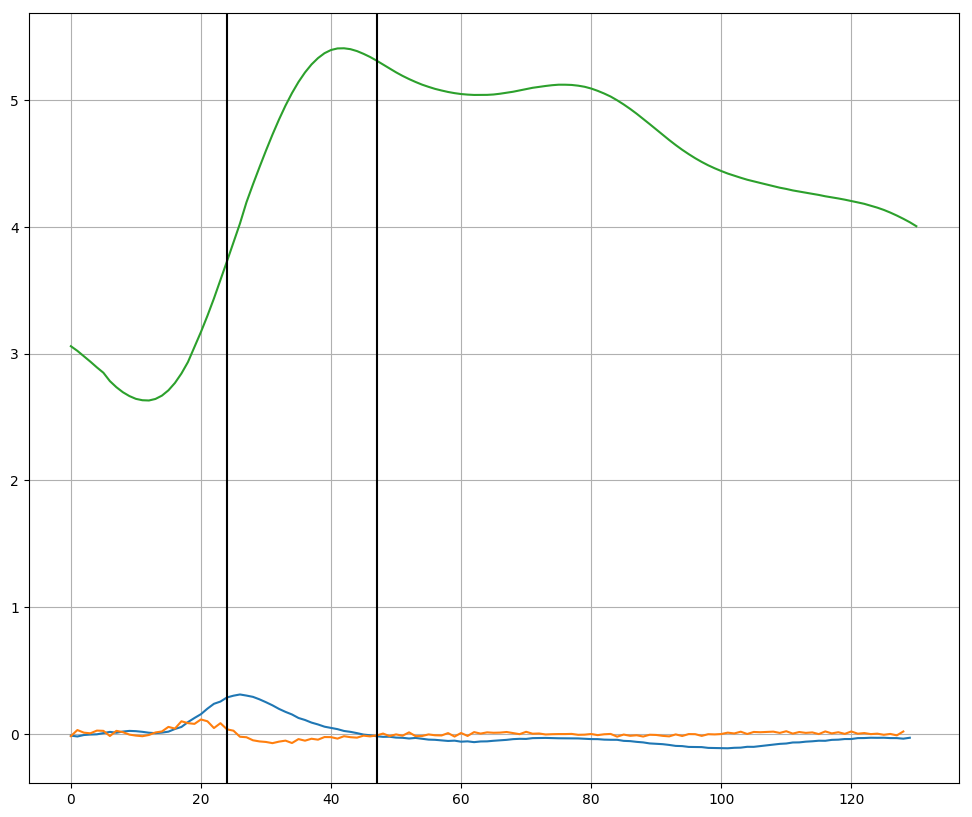

In [97]:
#plot(promSpK)
figure(figsize=(12,10))
plot(difProm)
plot(ddprom)
plot(promSpK.+70)
axvline(x=riset[1], c="black")
axvline(x=riset[2], c="black")

grid()

In [98]:
(riset[2]-riset[1])/freq

8.832

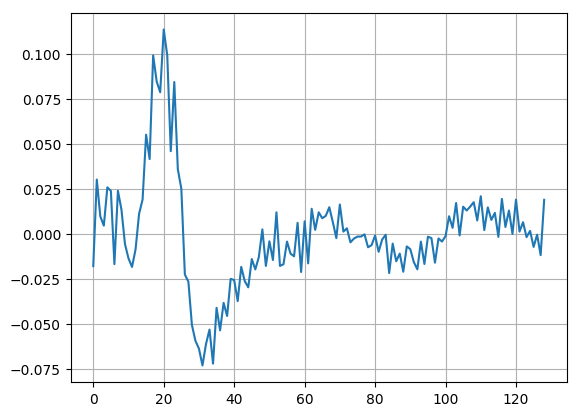

In [99]:
plot(ddprom)
grid()

In [100]:
difProm=derivadadt(promSpK)
ddprom=derivadadt(difProm)

129-element Array{Float64,1}:
 -0.03791321236557704  
 -0.005771119662307163 
 -0.013959705950511898 
  0.020402966207062296 
 -0.1627829274974494   
  0.12246404664935914  
  0.057359023567789526 
  0.06345303811424902  
  0.05574496636257668  
  0.07608185158867402  
  0.059646379115814746 
  0.09567571972709998  
  0.09592697484759001  
  ⋮                    
 -0.006079909116865003 
 -0.00690374205921986  
 -0.003959573367968983 
 -0.0005233535156172012
 -0.023530023242924553 
 -0.004149419803898028 
 -0.017485957205143027 
 -0.021311610117850467 
 -0.016349510412858183 
 -0.013703379858697682 
 -0.012976169631187362 
 -0.025643963681613275 

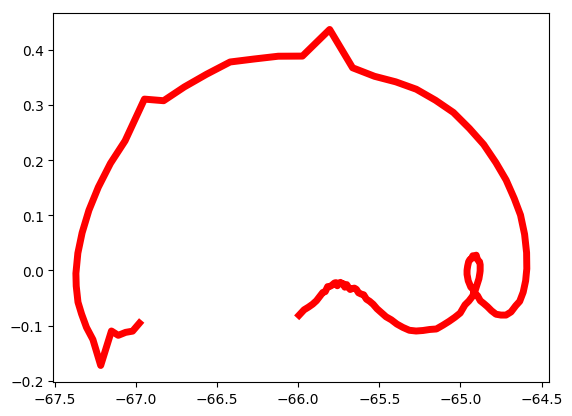

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f467edc0e80>

In [101]:
plot(promSpK[2:end],difProm, lw=5, c="red")

## A partir de aquí estamos guardando datos

In [ ]:
using DelimitedFiles

In [ ]:
datos=hcat(promSpK[2:end],difProm)

In [ ]:
writedlm("../h5files/masterspikelet.dat", datos)

In [ ]:
nota="Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  "*nomine

In [ ]:
h5open("../h5files/masterspiklet.h5", "w") do file
   write(file, "voltaje", promSpK[2:end])  # alternatively, say "@write file A"
    write(file, "derivative", difProm)  # alternatively, say "@write file A"
    write(file, "nota", nota)  # alternatively, say "@write file A"
end


In [ ]:

test = h5open("../h5files/masterspiklet.h5", "r");
names(test)

In [ ]:
#using HDF5